In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import fitClus2D as fc
from scipy.stats import sigmaclip
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier

import pandas as pd

In [36]:
cluster = 'a2744'
# Get galaxy data, make arrays for known cluster/noncluster members, 
data = pd.read_csv("Files/" + cluster+'_master.csv')
unknown = []
clusterarr = []
ncluster = []
clustz = 0.308
cut = 0.03

for i, row in data.iterrows():
    if not np.isnan(row['master_mag606']) and not np.isnan(row['master_mag814']) and row['master_d'] < 120 and row['master_mag814'] < 23.5:
        if np.isnan(row['master_z']):
            unknown.append(row)
        else:
            if abs(row['master_z'] - clustz) < cut:
                clusterarr.append(row)
            else:
                ncluster.append(row)

#Clip redshifts
clusterz = np.array([row['master_z'] for row in clusterarr])
arr, low, high = sigmaclip(clusterz, 3, 3)
tmpclust = []

for row in clusterarr:
    if row['master_z'] > low and row['master_z'] < high:
        tmpclust.append(row)
    else:
        ncluster.append(row)
clusterarr = tmpclust

#Create feature and category arrays for knowns, and feature array for unknowns
XclustCM= [[row['master_mag814'], row['master_mag606'] - row['master_mag814']] for row in clusterarr]
XnclustCM = [[row['master_mag814'], row['master_mag606'] - row['master_mag814']] for row in ncluster]
Xcm = np.array(XclustCM + XnclustCM)

unknownXcm = [[row['master_mag814'], row['master_mag606'] - row['master_mag814']] for row in unknown]
unknownXcm = np.array(unknownXcm)

clustnum = len(clusterarr)
nclustnum = len(ncluster)

y = np.zeros(clustnum + nclustnum)
y[:len(clusterarr)] = 1

In [37]:
#Ways to assign probabilities
def normalize(X, p):
    copyX = np.copy(X)
    copyp = np.copy(p)
    for i in range((len(X[0]))):
        mn = np.min(X[:,i])
        mx = np.max(X[:,i])
        copyX[:,i] = (X[:,i] - mn) / (mx - mn)
        copyp[:,i] = (p[:,i] - mn) / (mx - mn)
    
    return copyX, copyp
    
def Knn(X, y, p, k):
    normX, normp = normalize(X, p)
    model = KNeighborsClassifier(n_neighbors = k)
    model.fit(normX, y)
    return model.predict_proba(normp)[:,1], model.predict(normp)

def Rnn(X, y, p, r):
    normX, normp = normalize(X, p)
    model = RadiusNeighborsClassifier(radius = r, outlier_label = 0)
    model.fit(normX, y)
    return model.predict_proba(normp)[:,1], model.predict(normp)

def box(X, y, p, numx, numy):
    minm = np.min(Xcm[:,0])
    maxm = np.max(Xcm[:,0])
    minc = np.min(Xcm[:,1])
    maxc = np.max(Xcm[:,1])
    w = maxm - minm
    h = maxc - minc
    minm -= 0.01 * w
    maxm += 0.01 * w
    minc -= 0.01 * h
    maxc += 0.01 * h
    
    boxw = (maxm - minm) / numx
    boxh = (maxc - minc) / numy
    grid = np.zeros((numx, numy, 2))
    
    for i, point in enumerate(X):
        xcoor = int((point[0] - minm) / boxw)
        ycoor = int((point[1] - minc) / boxh)
        grid[xcoor, ycoor, 1] += 1
        grid[xcoor, ycoor, 0] += y[i]
        
    probs = np.zeros(len(p))
    classes = np.zeros(len(p))
    
    for i, point in enumerate(p):
        if point[0] >= minm and point[0] < maxm and point[1] >= minc and point[1] <= maxc:
            xcoor = int((point[0] - minm) / boxw)
            ycoor = int((point[1] - minc) / boxh)
            if not grid[xcoor, ycoor, 1] == 0:
                probs[i] = grid[xcoor, ycoor, 0] / grid[xcoor, ycoor, 1]
                if probs[i] > 0.5: classes[i] = 1
                    
    return probs, classes

def sigmaCut(X, y, p, k):
    clustermag = [dat[0] for i, dat in enumerate(X) if y[i] == 1]
    clustercolor = [dat[1] for i, dat in enumerate(X) if y[i] == 1]
    
    model = np.polyfit(clustermag, clustercolor, 1)
    predict = np.poly1d(model)
    
    sigma = np.std(clustercolor)
    
    probs = np.zeros(len(p))
    classes = np.zeros(len(p))
    
    nclust = 0
    ntot = 0
    
    for i, point in enumerate(X):
        if abs(point[1] - predict(point[0])) < k * sigma:
            if y[i] == 1:
                nclust += 1
            ntot += 1
    prob = nclust / ntot
    
    for i, point in enumerate(p):
        if abs(point[1] - predict(point[0])) < k * sigma:
               probs[i] = prob
               classes[i] = 1
    return probs, classes

In [38]:
clusterData = [[row['master_x'], row['master_y'], row['master_mag814'], 1] for row in clusterarr]
unknownData = [[row['master_x'], row['master_y'], row['master_mag814'], 0] for row in unknown]
data = np.array(clusterData + unknownData)


    
#draw scatter plot of uncertainties in varying cluster members, or in scattering
def scatterDraw(n, vclust, scatter, ax, probs = []):
    global data
    colors = ["red", "blue", "green"]
    if vclust: data[clustnum:,3] = probs
    
    gal = fc.galclass(data)
    gal.scale()
    alldeflect = []
    
    for i in range(n):
        gal.draw(True, scatter)
        deflect, gamma = gal.calcdefbasic(images)
        alldeflect.append(deflect)

    alldeflect = np.array(alldeflect)
    for i in range(len(images)):
        x = alldeflect[:,i,0]
        y = alldeflect[:,i,1]
        ax.scatter(x, y, color = colors[i])


In [22]:
#Get probability arrays
knnprob = Knn(Xcm, y, unknownXcm, 20)[0]
rnnprob = Rnn(Xcm, y, unknownXcm, 0.25)[0]
boxprob = box(Xcm, y, unknownXcm, 3, 5)[0]

Read in 351 galaxies


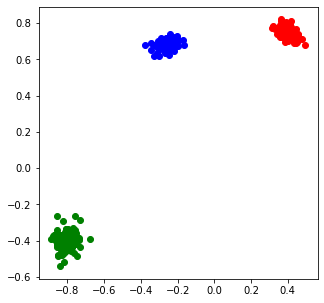

In [42]:
fig,ax = plt.subplots(figsize=(5,5))
classes = sigmaCut(Xcm, y, unknownXcm, 1.0)[1]

images = np.array([[20, 25], [-13, 26], [-1, 2]])
scatterDraw(100, True, True, ax, classes)

Read in 351 galaxies
Read in 351 galaxies
Read in 351 galaxies


Text(0.5, 1.0, 'Boxes')

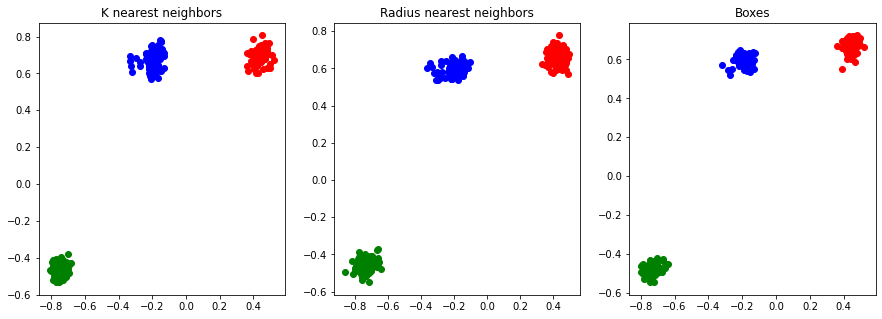

In [28]:
fig,((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15,5))

scatterDraw(100, True, False, ax1, knnprob)
scatterDraw(100, True, False, ax2, rnnprob)
scatterDraw(100, True, False, ax3, boxprob)
ax1.set_title("K nearest neighbors")
ax2.set_title("Radius nearest neighbors")
ax3.set_title("Boxes")

Read in 351 galaxies
Read in 351 galaxies
Read in 351 galaxies


Text(0.5, 1.0, 'Boxes')

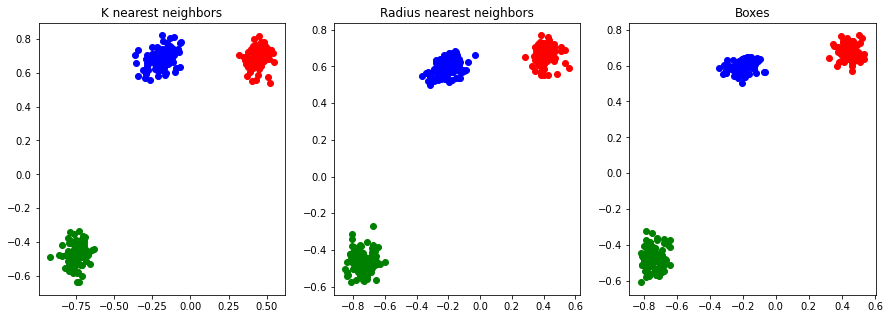

In [29]:
fig,((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15,5))

scatterDraw(100, True, True, ax1, knnprob)
scatterDraw(100, True, True, ax2, rnnprob)
scatterDraw(100, True, True, ax3, boxprob)
ax1.set_title("K nearest neighbors")
ax2.set_title("Radius nearest neighbors")
ax3.set_title("Boxes")